
## Trabalho 1 

1. Para um distribuidor de encomendas o seu território está organizados em pontos (“nodes”) de fornecimento (“sources”), pontos de passagem  e pontos de entrega (“sinks”) ligados por vias de comunicação (“edges”) bidirecionais cada uma das quais associada uma capacidade em termos do número de veículos de transporte que suporta.
2. Os items distribuidos estão organizados em “pacotes” de três tipos “standard” : uma unidade, duas unidades e cinco unidades. Os pacotes são transportados em veículos todos com a capacidade de 10 unidades. Cada ponto de entrega tem um limite no número total de unidades que tem em “stock” e um limite no número de veículos que dispõe.
3. Cada encomenda é definida por o identificador do ponto de entrega e pelo número de pacotes, de cada um dos tipos, que devem ser entregues nesse ponto.
4. O objetivo do problema é decidir, a partir de uma encomenda e com um mínimo no número de veículos,



### - S = lista de sources (origens)
    # - T = lista de sinks (destinos)
    # - G = grafo com nós e arestas
    # - cap[(i,j)] = capacidade de cada aresta
    # - stock[s][k] = estoque de cada source por tipo de pacote
    # - demand[t][k] = demanda de cada sink por tipo de pacote
    # - veh_limit[t] = limite de veículos que cada sink pode receber
    # - package_types = {1:1, 2:2, 5:5} -> tipo de pacote : unidades
    # - C = capacidade de cada veículo (ex: 10 unidades)
        

        - em cada ponto de fornecimento,  se estará envolvido no fornecimento de unidades que essa encomenda requer sem violar os limites do seu “stock”.
        - em cada ponto de entrega,   como empacotar as unidades disponíveis, de acordo com a encomenda”,  e como as distribuir por veículos,
        - em cada veículo, qual o percurso a seguir até  ao ponto de entrega; para cada via ao longo de cada percurso, o total de veículos não pode exceder a capacidade dessa via.

In [3]:
import networkx as nx
from ortools.linear_solver import pywraplp
import math
# Criar instância do solver
solver = pywraplp.Solver.CreateSolver('SCIP')

Fazendo o grafo (fazer aleatorio dps) (fazer a cores)

{(1, 2): Text(0.6952738563736374, 0.4882820739115259, '3'),
 (1, 4): Text(0.2347927747728602, 0.5075577262002617, '1'),
 (2, 3): Text(-0.23478904308577364, -0.5075550873055837, '1'),
 (2, 4): Text(0.0026448888584307273, 0.004171546496987588, '4'),
 (3, 4): Text(-0.6952710876048995, -0.48827603410946896, '3')}

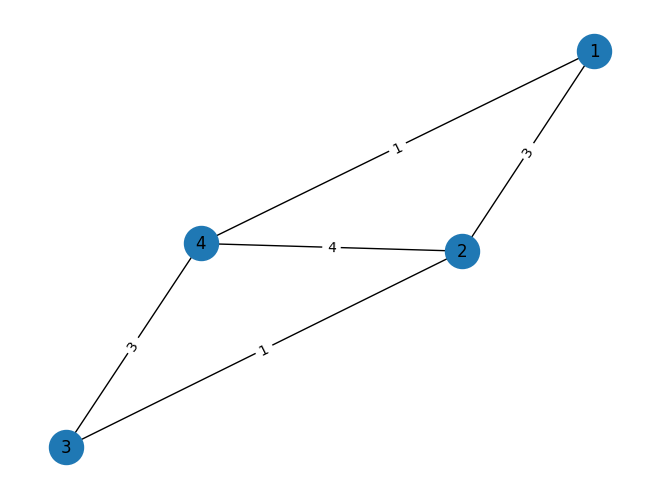

In [4]:
G = nx.Graph()

G.add_edges_from([
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 1),
    (2, 4)
])

G.nodes[1]['type'] = 'src'
G.nodes[1]['stock'] = (15,3,2)
G.nodes[4]['type'] = 'node'
G.nodes[2]['type'] = 'node'
G.nodes[3]['type'] = 'sink'
G.nodes[3]['demand'] = (4,2,1)

G[1][2]['weight'] = 3
G[1][4]['weight'] = 1
G[2][4]['weight'] = 4
G[2][3]['weight'] = 1
G[3][4]['weight'] = 3



pos = nx.spring_layout(G, seed=42)
edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw(G, pos, with_labels=True, node_size=600, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


In [5]:

print(G.edges)
print(G.nodes.data())
print(G.edges.data())

def sumT(x,y,a,b):
    return (x+a,y+b)


from operator import itemgetter

p1 = itemgetter(0)  # primeira projeção
p2 = itemgetter(1)  # segunda projeção


[(1, 2), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, {'type': 'src', 'stock': (15, 3, 2)}), (2, {'type': 'node'}), (3, {'type': 'sink', 'demand': (4, 2, 1)}), (4, {'type': 'node'})]
[(1, 2, {'weight': 3}), (1, 4, {'weight': 1}), (2, 3, {'weight': 1}), (2, 4, {'weight': 4}), (3, 4, {'weight': 3})]


In [ ]:
c = 10 #capaciade de cada veiculo
pack_type = {1:1, 2:2,5:5}

# G é o nosso grafo 
# T lista de sinks 

def routes(Graph: G, pack_type, c):


    V = dict()
    demand = dict() # por cada sink tens uma demanda sendo um (x1,x2,x3)
    stock = dict() # stock por cada src envolvendo um k igual a cima
    cap = dict() # guarda as capacidades das edges

    for edge in G.edges:
        cap[edge] = G.edges[edge]["weight"]

    for node in G.nodes:

        if G.nodes[node]["type"] == 'src':
            (s,m,l) = G.nodes[node]["stock"] #guardamos o stock
            
            stock[node] = {
            "stock": (s, m, l),
            "V": math.ceil((s + m*2 + l*5) / 10)
            }

        if G.nodes[node]["type"] == 'sink':
            (s,m,l) = G.nodes[node]["demand"]
            #print((s,m,l))

            demand[node] = (s,m,l)

        v = sum([stock[x]["V"] for x in stock.keys()]) 
       
        
        

    sink_filled = dict()   # sink_filled[node] = 1 sse ja esta entregue

        

    V = dict() # se o veiculo saiu ou nao

    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V[(node,carro)] = solver.IntVar(0,1,f"V[{node}][{carro}]")

    V_ocup = dict() # oq cada veiculo leva (s,m,l)

    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V_ocup[(node,carro)] = (solver.IntVar(0,50,f"V[{node}][{carro}]S"),solver.IntVar(0,50,f"V[{node}][{carro}]M"),solver.IntVar(0,50,f"V[{node}][{carro}]L")) #oq cada carro leva


    X = dict() #ruas com carro se um carro especifico esta na rua ou nao 

    for (a,b) in G.edges:
        for (node,carro) in V.keys():
            X[(a,b,node,carro)] = solver.IntVar(0,1,f"X[{(a,b,node,carro)}]") #importante
        
        
    for (a,b) in G.edges:
        solver.Add(sum([X[a,b,src,carro] for (src,carro) in V.keys()]) <= cap[(a,b)]) # 1. PRIMEIRA RESTRIÇÃO MAXIMO DA ESTRADA                for node in G.nodes:
        sink_filled[node] = solver.IntVar(0,1,f"sink_filled[{node}]")
        
        solver.Add(sink_filled[node] == 1) # 2. restrição quero entregar tudo (falta fazer a conexão)

    for (node,carro), (Vs,Vm,Vl) in V_ocup.items():
        solver.Add((Vs + 2*Vm + 5*Vl) <= c * V[(node,carro)])  # 3. Restrição: capacidade total do veículo

    for node in stock.keys(): #4. Restrição os carros de um n stock nao levem todo o estoque
        solver.Add( tuple(map(sum,zip(*[V_ocup[(node,carro)] for carro in tuple(map(p2,list(V_ocup.keys()))) ]))) <= stock[node]["stock"] )

    for node in demand.keys(): # 5. Restrição dos nós de entrega tem que estar entregue
        solver.Add(  [V_ocup[(node,carro)] for carro in X.keys()] == demand[node]["stock"])
 
    print(  tuple(map(p2,list(V_ocup.keys()))) )
    
    #print(stock.keys())
    #for sink in demand.keys():
    #    print(sink)
    #    conectores = [(a,b) for (a,b) in G.edges if b == sink ]
    #    for (x,y) in conectores:
    #        solver.
                
                


        #for (a,b) in G.edges



        
        

            


        
        
        

    #print(sum([stock[x]["V"] for x in stock.keys()])) numero de veiculos


    



    return False


routes(G,pack_type,c)

(0, 1, 2, 3)


False

In [24]:
(1,2)==(1,2)

True

In [8]:
tuple(map(sum,zip(*[(1,2,3),(1,2,3),(1,2,3)])))

(3, 6, 9)

In [ ]:
import math
from ortools.linear_solver import pywraplp

def add_tuple_eq(solver, left, right):
    for j in range(len(left)):
        solver.Add(left[j] == right[j])


def routes(G, pack_type, c):
    solver = pywraplp.Solver.CreateSolver("SCIP")

    V = dict()
    demand = dict()   # demanda por sink (x1,x2,x3)
    stock = dict()    # estoque por src (x1,x2,x3)
    cap = dict()      # capacidade das edges

    # 0. Capacidade de cada aresta
    for edge in G.edges:
        cap[edge] = G.edges[edge]["weight"]

    # 1. Extrai stocks e demandas dos nós
    for node in G.nodes:
        if G.nodes[node]["type"] == "src":
            (s, m, l) = G.nodes[node]["stock"]
            stock[node] = {
                "stock": (s, m, l),
                "V": math.ceil((s + 2*m + 5*l) / 10)
            }

        if G.nodes[node]["type"] == "sink":
            (s, m, l) = G.nodes[node]["demand"]
            demand[node] = (s, m, l)

 
    v = sum(stock[x]["V"] for x in stock.keys())

    # 2. Variáveis: se o veículo existe ou não
    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V[(node, carro)] = solver.IntVar(0, 1, f"V[{node}][{carro}]")

    # 3. Variáveis: ocupação de cada veículo (S, M, L)
    V_ocup = dict()
    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V_ocup[(node, carro)] = (
                solver.IntVar(0, 10, f"V[{node}][{carro}]S"),
                solver.IntVar(0, 5, f"V[{node}][{carro}]M"),
                solver.IntVar(0, 2, f"V[{node}][{carro}]L")
            )

    # 4. Variáveis: se um carro específico percorre uma edge
    X = dict()
    for (a, b) in G.edges:
        for (node, carro) in V.keys():
            X[(a, b, node, carro)] = solver.IntVar(0, 1, f"X[{(a,b,node,carro)}]")

    # 5. Restrição: capacidade das estradas
    for (a, b) in G.edges:
        solver.Add(sum(X[a, b, src, carro] for (src, carro) in V.keys()) <= cap[(a, b)])

        # variáveis: carro (src,carro) vai para sink `node`?
    Z = {}
    for (src,carro) in V.keys():
        for node in demand.keys():
            Z[(src,carro,node)] = solver.IntVar(0, 1, f"Z[{src},{carro},{node}]")
    
  
    # unicidade: cada carro atende no máximo 1 sink
    for (src,carro) in V.keys():
        solver.Add(sum(Z[(src,carro,node)] for node in demand.keys()) <= 1)

    # 6. Variáveis: se um sink foi atendido
    sink_filled = dict()
    for node in demand.keys():
        sink_filled[node] = solver.IntVar(0, 1, f"sink_filled[{node}]")
        solver.Add(sink_filled[node] == 1)  # (ajustar depois se quiser relaxar isso)

    # 7. Restrição: capacidade de cada veículo (S=1, M=2, L=5)
    for (node, carro), (Vs, Vm, Vl) in V_ocup.items():
        solver.Add(Vs + 2*Vm + 5*Vl <= c * V[(node, carro)])

    # 8. Restrição: não ultrapassar estoque dos src
    for node in stock.keys():
        for j in range(3):
            solver.Add( sum([V_ocup[(node, carro)][j] for carro in range(stock[node]["V"])]) <= stock[node]["stock"][j] )


    for (a,b,src,carro), x in X.items():
        solver.Add(x <= V[(src,carro)])



    M = 50
    Y = {}
    for (src,carro) in V.keys():
        for sink in demand.keys():
            for j in range(3):
                Y[(src,carro,sink,j)] = solver.IntVar(0, M, f"Y[{src},{carro},{sink},{j}]")
    
                Vj = V_ocup[(src,carro)][j]
                z  = Z[(src,carro,sink)]
                y  = Y[(src,carro,sink,j)]
    
                solver.Add(y <= Vj)
                solver.Add(y <= M * z)
                solver.Add(y >= Vj - M*(1-z))

    for sink in demand.keys():
        for j in range(3):
            solver.Add( sum(Y[(src,carro,sink,j)] for (src,carro) in V.keys()) == demand[sink][j])   

    for (src,carro) in V.keys():
        for sink in demand.keys():
            solver.Add(Z[(src,carro,sink)] <= V[(src,carro)])
        
    # 9. Restrição: demandas dos sinks devem ser satisfeitas
   # for node in demand.keys():
        #soma = tuple(map(sum,zip(*[V_ocup[(src, carro)] for src in stock.keys() for carro in [c for (a,b,src_node,c) in X.keys() if b == node and src_node == src] ])))  
        ##soma = []

       # for src in stock.keys():
            #for (a,b,src_node,c) in X.keys():
               # if src_node == src and b == node:
                    #soma.append(V_ocup[src,c]) #*X[a,b,src_node,c]
                    #solver.Add( sum(V_ocup[src,c]) <= X[a,b,src_node,c]*50) 
        #print(soma)
       # soma = tuple(map(sum,zip(*soma)))
       # #somanova = [n for n in soma if len(n) > 0]
        #"<" and ">"
       # for j in range(len(soma)):
            #solver.Add(soma[j] == demand[node][j])

    #10. Restrição: Se o veiculo estiver com material na  
    #for a,b,n,c in X.keys():
        #solver.Add(Implies(sum(list(V_ocup[n,c]))>0,X[a,b,n,c]))
    

    solver.Minimize(sum(list( V.values()) ))
        #for (a,b) in G.edges



    status = solver.Solve()
    
    if status == solver.OPTIMAL or status == solver.FEASIBLE:

        print("=== Veículos usados ===")
        for (node, carro), var in V.items():
            if var.solution_value() > 0.5:
                carga = tuple(v.solution_value() for v in V_ocup[(node, carro)])
                print(f"Carro {carro} do node {node}: ativo, leva S={carga[0]}, M={carga[1]}, L={carga[2]}")

        print("\n=== Fluxo nas estradas ===")
        #for (a, b, node, carro), var in X.items():
        #    print(f"Carro {carro} de {node} passa em ({a}->{b}) {X[a,b,node,carro].solution_value()}")

        for (src,carro,node) in Z.keys():
            print(f"{src} {carro} {node} : {Z[(src,carro,node)].solution_value()}")
            
        print("\n=== Fluxo nas estradas ===")
        
        print("\n=== Demandas ===")
        for node, d in demand.items():
            print(f"Sink {node} demanda {d}")
            
        for (src,carro,sink,j) in Y.keys():
            print(f"{src} {carro} {node} {j} : {Y[(src,carro,node,j)].solution_value()}")
            
        print("\n=== Estoques ===")
        for node, s in stock.items():
            print(f"Src {node} estoque {s['stock']}")
    else:
        print("Nenhuma solução encontrada.")


routes(G,pack_type,c)


